### optimised algorithms for change point detection 

#### Python package ruptures 

#### simulation using simulated data, gridsearch for optimal parameters

author: peter

date: 2024

Ruptures: 

C. Truong, L. Oudre, N. Vayatis. Selective review of offline change point detection methods. Signal Processing, 167:107299, 2020.

<li> https://centre-borelli.github.io/ruptures-docs/
<li> https://github.com/deepcharles/ruptures
<li> https://centre-borelli.github.io/ruptures-docs/user-guide/detection/
<li> see also https://schuetzgroup.github.io/sdt-python/changepoint.html


<br><br>
#### simulation 
For each algorithm:
<li>For each trial:
<li>  &nbsp; For each cost in cost set:
<li>   &nbsp;  &nbsp;   generate a new simulated dataset
<li>   &nbsp;  &nbsp;   test algorithm

<br><br>
Use metrics to compare algorithm performance:
<li>too early
<li>MAE
<li>std

In [5]:
import matplotlib.pylab as plt
import ruptures as rpt
import h5py
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.ticker import PercentFormatter

### run simulation and collect performance measurements

In [6]:
### set simulation parameters
#
my_rand_seed = 12345

num_signals = 1000  # number of trials in simulation

mu, sigma = 0, 3 # mean and standard deviation
mu2, sigma2 = mu + 1, sigma + 1
n_bkps=1
true_onset=200

times = np.arange(0, 451, 1).tolist()

# Note: algorithms: when using defaults make defaults explicit.
# A new Pelt algorithm object must created for each trial.
# This might also be true for other algorithm implementations.
# Negligible performance hit, so no need to optimise.

# can't use 'linear' cost function, not enough dimensions.
mdl_list =['l1', 'l2', 'normal', 'rbf', 'cosine', 'clinear', 'rank', 'mahalanobis', 'ar']

### simulated data generation

In [7]:
def make_data(mu, sigma, mu2, sigma2, true_onset, rng):
    s1 = rng.normal(mu, sigma, true_onset-1)
    s2 = rng.normal(mu2, sigma2, 251)
    signal= np.array(list(s1) + list(s2))
    return signal

### Binseg

In [ ]:
binseg_list = []

for mdl in mdl_list:
    binseg_predictions = []
    rng = np.random.default_rng(my_rand_seed)  
    for ii in range(num_signals):
        # generate signal
        signal = make_data(mu, sigma, mu2, sigma2, true_onset, rng)

        # Binseg algorithm
        algo = rpt.Binseg(model=mdl, custom_cost=None, min_size=2, jump=5, params=None).fit(signal)
        est_onset = algo.predict(n_bkps=n_bkps)
        binseg_predictions.append(est_onset[0])
    binseg_list.append(binseg_predictions)

### Pelt

In [9]:

pelt_list = []

for mdl in mdl_list:
    pelt_predictions = []
    rng = np.random.default_rng(my_rand_seed)
    for ii in range(num_signals):
        # generate signal
        signal = make_data(mu, sigma, mu2, sigma2, true_onset, rng)
        
        # Pelt algorithm
        algo = rpt.Pelt(model=mdl, custom_cost=None, min_size=2, jump=5, params=None).fit(signal)
        est_onset = algo.predict(pen=2)           # penalty 1 --> early, 10 --> late
        pelt_predictions.append(est_onset[0])
    pelt_list.append(pelt_predictions)

### Window

In [10]:

window_list = []

for mdl in mdl_list:
    window_predictions = []
    rng = np.random.default_rng(my_rand_seed)
    for ii in range(num_signals):
        # generate signal
        signal = make_data(mu, sigma, mu2, sigma2, true_onset, rng)
        
        # window algorithm
        algo = rpt.Window(width=100, model=mdl, custom_cost=None, min_size=2, jump=5, params=None).fit(signal)
        est_onset = algo.predict(n_bkps=n_bkps)
        window_predictions.append(est_onset[0])
    window_list.append(window_predictions)

### Dynamic Programming

In [11]:
dp_list = []

for mdl in mdl_list:
    dp_predictions = []
    rng = np.random.default_rng(my_rand_seed)
    for ii in range(num_signals):
        # generate signal
        signal = make_data(mu, sigma, mu2, sigma2, true_onset, rng)
        
        # Dynamic programming algorithm
        algo = rpt.Dynp(model=mdl, custom_cost=None, min_size=2, jump=5, params=None).fit(signal)
        est_onset = algo.predict(n_bkps=n_bkps)
        dp_predictions.append(est_onset[0])
    dp_list.append(dp_predictions)

### helper functions

In [12]:
def get_too_early(predictions, true_onset):
    pred_array = np.array(predictions)
    too_early = pred_array[pred_array < true_onset]
    too_early = np.abs(too_early - true_onset)
    return too_early


def get_pct_too_early(predictions, true_onset):
    pred_array = np.array(predictions)
    too_early = pred_array[pred_array < true_onset]
    pct_too_early = len(too_early)/len(predictions)
    return pct_too_early


def get_MAE(predictions, true_onset):
    pred_array = np.array(predictions)
    MAE = np.mean(np.abs(pred_array - true_onset))
    return MAE

def get_std(predictions, true_onset):
    pred_array = np.array(predictions)
    std = np.std(pred_array)
    return std


def plot_predictions(pred, title):
    pass


### choose model index for plotting [0..8]
mdl_list =['l1', 'l2', 'normal', 'rbf', 'cosine', 'clinear', 'rank', 'mahalanobis', 'ar']

In [18]:
mdl_idx=2

### plot prediction distribution for each algorithm

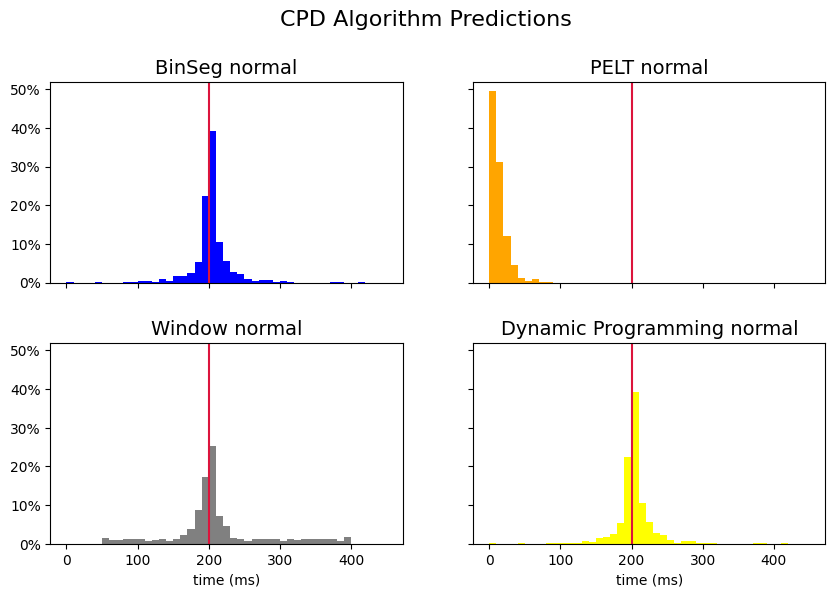

In [19]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=True, sharey=True)
fig.suptitle('CPD Algorithm Predictions', y=1, fontsize=16)

fig.set_figwidth(10)
fig.set_figheight(6)

plt.subplots_adjust(hspace = 0.3)
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1,  decimals=0))

binwidth=10
bins = np.linspace(0, 450, 46)
mdl  = mdl_list[mdl_idx]

temp=binseg_list[mdl_idx]
ax1.hist(temp, color='blue', bins=bins,  weights=np.ones(len(temp)) / len(temp))
ax1.set_title(("BinSeg %s" % mdl), fontsize=14)
ax1.axvline(200, c="crimson", label="real onset")

temp=pelt_list[mdl_idx]
ax2.hist(temp, color='orange', bins=bins,  weights=np.ones(len(temp)) / len(temp))
ax2.set_title(("PELT %s" % mdl), fontsize=14)
ax2.axvline(200, c="crimson", label="real onset")

temp=window_list[mdl_idx]
ax3.hist(temp, color='gray', bins=bins,  weights=np.ones(len(temp)) / len(temp))
ax3.set_title(("Window %s" % mdl), fontsize=14)
ax3.set_xlabel("time (ms)")
ax3.axvline(200, c="crimson", label="real onset")

temp = dp_list[mdl_idx]
ax4.hist(temp, color='yellow', bins=bins,  weights=np.ones(len(temp)) / len(temp))
ax4.set_title( ("Dynamic Programming %s" % mdl), fontsize=14)
ax4.set_xlabel("time (ms)")
ax4.axvline(200, c="crimson", label="real onset")

for ax in fig.get_axes():
    ax.label_outer()

### plot distribution as in (Sassenhagen and Draschkow, 2019)

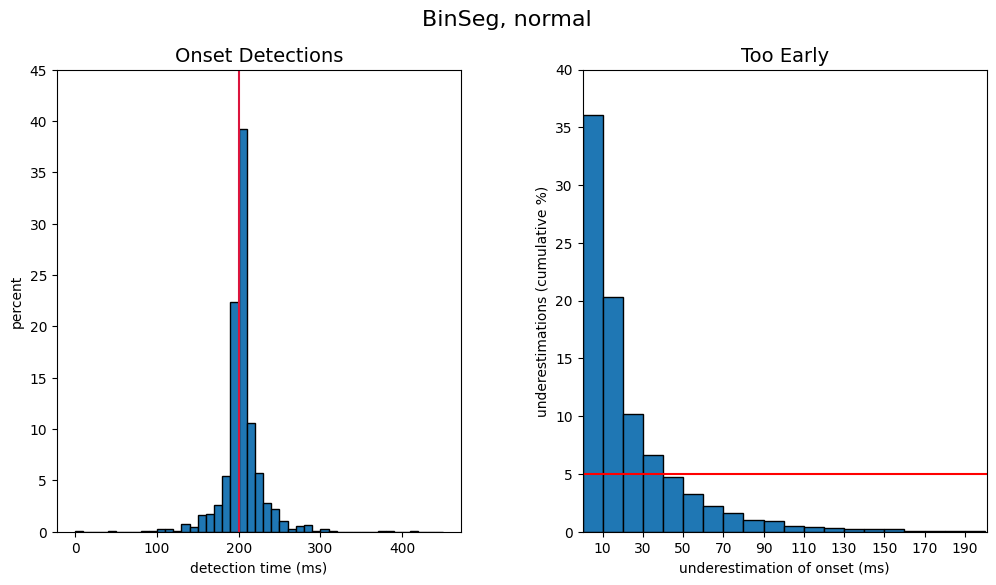

In [20]:
fig, [ax1, ax2] = plt.subplots(ncols=2)
fig.set_figwidth(12)
fig.set_figheight(6)

mdl=mdl_list[mdl_idx]
plt.suptitle( ("BinSeg, %s" % mdl), fontsize=16)

# 10 ms time steps, 10ms bin width
binwidth=10
bins = np.linspace(0, 450, 46)
claims=binseg_list[mdl_idx]

ax1.hist(claims,  edgecolor='black', bins=bins,  weights=np.ones(len(claims)) / len(claims))
ax1.set_title(("Onset Detections"), fontsize=14)
ax1.axvline(200, c="crimson", label="real onset")
ticks=ax1.get_yticks()
ax1.set_yticks(ticks)
ticks=ticks*100
ticks = [int(v)for v in ticks]
ax1.set_yticklabels(ticks);
ax1.set_xlabel("detection time (ms)")
ax1.set_ylabel("percent")

plt.subplots_adjust(wspace = 0.3)
total_claims = len(claims) # total number of claims (predictions)

ax2.axhline(0.05, c="r", label="nominal 5% level")
ax2.set_ylabel("underestimations (cumulative %)")
ax2.set_xlabel("underestimation of onset (ms)")
ax2.set_xlim([0, 201])
ax2.set_xticks(range(10,201,20))

# this works better than sns histplot, etc, for reverse cumsum histogram
bin_width=10
bin_list = list(range(0, 201, bin_width))
too_early = [] 

for data_point in claims:
    if data_point < true_onset:
        data_point = abs(data_point - true_onset) 
        too_early.append(data_point)

plt.hist(too_early, edgecolor='black', align="mid", cumulative=-1, bins=bin_list, weights=np.ones(len(too_early)) / total_claims)
ax2.set_title(("Too Early"), fontsize=14)
ticks=ax2.get_yticks()
ax2.set_yticks(ticks)
ticks=ticks*100
ticks = [int(v)for v in ticks]
ax2.set_yticklabels(ticks);

In [21]:
bin_seg_mae_list=[]
pelt_seg_mae_list=[]
window_seg_mae_list=[]
dp_seg_mae_list=[]

min_idx=0
min_MAE=1000000
for ii, preds in enumerate(binseg_list):
    mdl = mdl_list[ii]
    MAE = get_MAE(preds, true_onset); bin_seg_mae_list.append(MAE)
    if MAE < min_MAE:
        min_MAE = MAE
        min_idx=ii
    std = get_std(preds, true_onset)
    print("BinSeg %11s: MAE = %6.2f ms, std=%6.2f" % (mdl, MAE, std))
print("Lowest MAE: %0.2f, cost function = %s" % (min_MAE, mdl_list[min_idx] )  )

print("\n")
min_idx=0
min_MAE=1000000
for ii, preds in enumerate(pelt_list):
    mdl = mdl_list[ii]
    MAE = get_MAE(preds, true_onset); pelt_seg_mae_list.append(MAE)
    if MAE < min_MAE:
        min_MAE = MAE
        min_idx=ii
    std = get_std(preds, true_onset)
    print("Pelt %11s: MAE = %6.2f ms, std=%6.2f" % (mdl, MAE, std) )
print("Lowest MAE: %0.2f, cost function = %s" % (min_MAE, mdl_list[min_idx] )  )


print("\n")
min_idx=0
min_MAE=1000000
for ii, preds in enumerate(window_list):
    mdl = mdl_list[ii]
    MAE = get_MAE(preds, true_onset); window_seg_mae_list.append(MAE)
    if MAE < min_MAE:
        min_MAE = MAE
        min_idx=ii    
    std = get_std(preds, true_onset)
    print("Window %11s: MAE = %6.2f ms, std=%6.2f" % (mdl, MAE, std) )
print("Lowest MAE: %0.2f, cost function = %s" % (min_MAE, mdl_list[min_idx] )  )


print("\n")
min_idx=0
min_MAE=1000000
for ii, preds in enumerate(dp_list):
    mdl = mdl_list[ii]
    MAE = get_MAE(preds, true_onset); dp_seg_mae_list.append(MAE)
    if MAE < min_MAE:
        min_MAE = MAE
        min_idx=ii   
    std = get_std(preds, true_onset)
    print("Dynamic Programming %11s: MAE = %6.2f ms, std=%6.2f" % (mdl, MAE, std) )
print("Lowest MAE: %0.2f, cost function = %s" % (min_MAE, mdl_list[min_idx] )  )

BinSeg          l1: MAE =  67.54 ms, std= 94.71
BinSeg          l2: MAE =  54.42 ms, std= 81.60
BinSeg      normal: MAE =  14.29 ms, std= 26.40
BinSeg         rbf: MAE =  26.31 ms, std= 47.14
BinSeg      cosine: MAE =  79.15 ms, std=107.41
BinSeg     clinear: MAE = 194.32 ms, std=191.52
BinSeg        rank: MAE =  51.63 ms, std= 78.67
BinSeg mahalanobis: MAE =  54.42 ms, std= 81.60
BinSeg          ar: MAE =  91.41 ms, std=110.38
Lowest MAE: 14.29, cost function = normal


Pelt          l1: MAE = 183.59 ms, std= 15.42
Pelt          l2: MAE = 192.21 ms, std=  4.82
Pelt      normal: MAE = 188.41 ms, std= 10.16
Pelt         rbf: MAE =  44.72 ms, std= 74.90
Pelt      cosine: MAE = 131.66 ms, std= 67.72
Pelt     clinear: MAE = 191.48 ms, std=  5.02
Pelt        rank: MAE = 147.08 ms, std= 51.90
Pelt mahalanobis: MAE = 126.97 ms, std= 64.11
Pelt          ar: MAE = 193.66 ms, std=  2.21
Lowest MAE: 44.72, cost function = rbf


Window          l1: MAE =  75.92 ms, std= 89.82
Window          l2: M

In [22]:
headers = mdl_list
data = dict()
data["Binseg"]   = bin_seg_mae_list
data["Pelt"]     = pelt_seg_mae_list
data["Window"]   = window_seg_mae_list
data["Dyn Prog"] = dp_seg_mae_list

textabular = f"l|{'r'*len(headers)}"
texheader = " & " + " & ".join(headers) + "\\\\"
texdata = "\\hline\n"
for label in data:
    texdata += f"{label} & {' & '.join(map(str,data[label]))} \\\\\n"
    if label == "Dyn Prog":
        texdata += "\\hline\n"

print("\\begin{table}")
print("\\caption{Mean Absolute Error (MAE)}")
print("\label{mae-table}")
print("\\begin{tabular}{"+textabular+"}")
print(texheader)
print(texdata, end="")
print("\\end{tabular}")
print("\\end{table}")


\begin{table}
\caption{Mean Absolute Error (MAE)}
\label{mae-table}
\begin{tabular}{l|rrrrrrrrr}
 & l1 & l2 & normal & rbf & cosine & clinear & rank & mahalanobis & ar\\
\hline
Binseg & 67.54 & 54.425 & 14.285 & 26.31 & 79.15 & 194.32 & 51.635 & 54.425 & 91.41 \\
Pelt & 183.585 & 192.205 & 188.41 & 44.715 & 131.665 & 191.48 & 147.08 & 126.965 & 193.665 \\
Window & 75.915 & 72.03 & 40.19 & 61.405 & 88.93 & 101.43 & 69.675 & 72.03 & 93.485 \\
Dyn Prog & 67.49 & 54.425 & 14.285 & 26.31 & 79.0 & 194.32 & 51.635 & 54.425 & 91.41 \\
\hline
\end{tabular}
\end{table}
